In [17]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
class Value:
    def __init__(self, data, _children=(), _op="", label="") -> None:
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self) -> str:
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self * other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    # raise to power expression
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self, ), f'**{other}')
        
        # the power derivative rule
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    # reverse multiplier expression
    def __rmul__(self, other):
        return self * other

    # division expression
    def __truediv__(self, other):
        return self * other**-1

    # negative expression
    def __neg__(self):
        return self * -1
    
    
    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        # i implemented the tanh hyperbolic function
        # it is an exponential
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out


    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        topo

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    

In [19]:
p = Value(2.0)

2 + p

Value(data = 4.0)

In [20]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #rank the direction from left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data,n.grad), shape="record")
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [21]:
# hyperbolic functions are important after capturing the x.w+b to give the neuron a balancing and normalization effect 

# this exponential expression balances our output to literally return between 0 to 1 as a means of validating our network training across its respective weights and biases

# in  this context what i learnt is that just as (f(x + h) - f(x))/h holds for the normal derivative of any expression 

# we can further translate that to be 
# x as our (weight and inputs) see below and h is our bias

# hyberbolic functions are best applied as or known too as activation functions

# lets have the two inputs just like we did for L1, L2
# inputs x1, x2

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(-1.0, label='w2')

# the bias of the neuron
b = Value(6.88137343345834, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# outut function
o = n.tanh(); o.label = 'o'

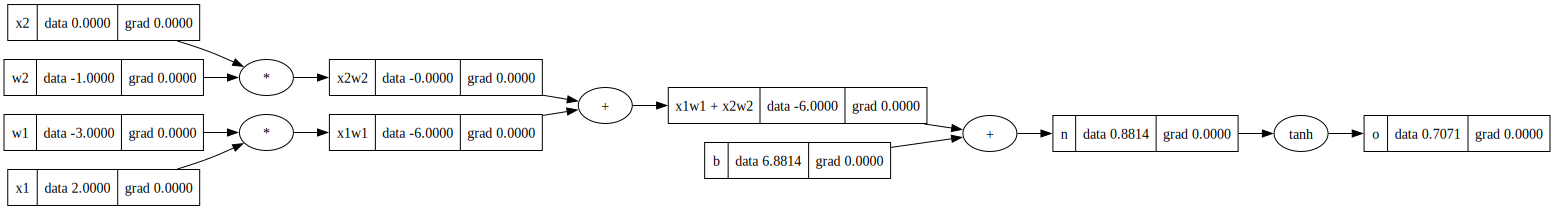

In [22]:
draw_dot(o)

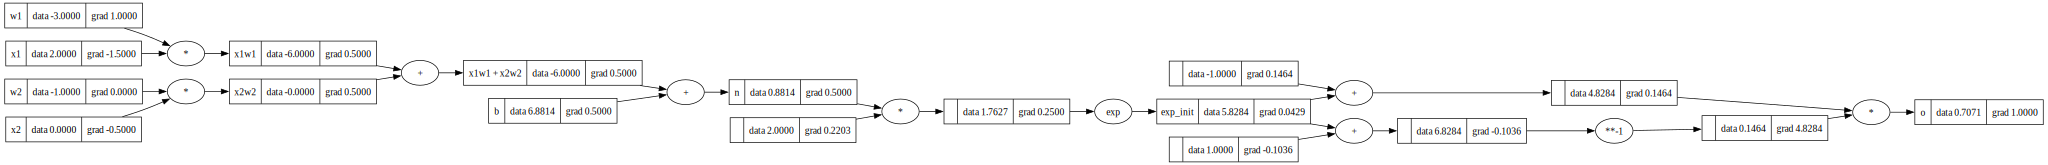

In [23]:

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(-1.0, label='w2')

# the bias of the neuron
b = Value(6.88137343345834, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# outut function
# o = n.tanh(); o.label = 'o'
e = (2*n).exp(); e.label = 'exp_init'
o = (e - 1) / (e + 1)
o.label = 'o'

o.backward()
draw_dot(o)

In [24]:
# i need to redefine the value expressor to adopt pytorch



In [25]:
# normal simple and single neuron

from numpy import random

class Neuron:
    # the init method asks for a weight which is measured by just a random np array then the value is kinda multiplied by a custom number of iterations...
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # let us pair up our w and x and sum it all up together zip = pair and sum
        # the purpose of this is to create a neuron output
        #  that pairs up the random weight we defined and add it up into a single value starting at the currently; randomly available bias.
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

# create a layer which is a list of neurons

class Layer:
    # construct a layer of nin neurons in nout places
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        # just give me the result in an arrray
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for n in self.neurons:
        #     ps = n.parameters()
        #     n.extend(ps)
        # return params

class MLP:
    # multi layer perceptron
    # construct a number of nin layers convert it into an array [nin] so it can provide an multi-array output from the input itself as an array
    # create your sublayers from the sum of its general size and distribute these layers into a bigger-structured MLP's layer 
    def __init__(self, nin, nout):
        sz = [nin] + nout
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nout))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]



In [26]:
# x = [2.0, 3.0]
# n = Layer(2, 4)
# n(x)

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
# draw_dot(n(x))
# n(x)

In [27]:
len(n.parameters())

41

In [28]:
x = [1, 5]
y = [5, 3, 9]

z = list(zip(x, y))
z


[(1, 5), (5, 3)]

In [29]:
# data definition the training and target 
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [30]:
# to tune the weight is to calculate a single number that measures the total performance of the network === the loss

# mean squared error loss or entropy loss
# [(yout, ygt) for ygt, yout in zip(ys, ypred)]

# INITIAL FORWARD PASS
ypred = [n(x) for x in xs]
ypred

loss = sum((yout  - ygt) ** 2 for ygt, yout in zip(ys, ypred))
loss


Value(data = 1.7311305545410576)

In [33]:
# forward pass after applying the parameter tuning

# let me automate the learning process

for k in range(20):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout  - ygt) ** 2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        # always remember to reset the grad to zero 
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        # define the learning rate 0.5 to tune with the grad (degree of change)
        p.data += -0.095 * p.grad
    
    print(k, loss.data)

0 0.023309745533766385
1 0.022080130236494334
2 0.02096912583923351
3 0.019960623043951322
4 0.01904127840580548
5 0.018199948407779335
6 0.017427256502938637
7 0.01671525814935618
8 0.016057178973935677
9 0.015447208144079115
10 0.014880333865025849
11 0.014352211340102193
12 0.013859055978511196
13 0.01339755640786692
14 0.012964803146765487
15 0.012558229753137001
16 0.012175563981655391
17 0.011814787024399049
18 0.011474099320210832
19 0.011151891733393343


In [34]:
ypred

[Value(data = 0.9152222243460315),
 Value(data = -0.9577814256228212),
 Value(data = -0.9456027450914058),
 Value(data = 0.919934886689886)]